# Application
The Iris dataset is useful for demonstrating SVM's, but are a bit _"too small to be representative of real world machine learning tasks"_<sup>web2</sup>. 

Furthermore, when comparing to other methods, we will probably do well no matter how our hyperparameters are set. So lets demonstrate its use on a larger (yet still manageable) dataset.

Name|		Data Type|	Meas.|	Description
----|		---------|	-----|	-----------
Sex	|	nominal		|	|    M, F, and I (infant)|
Length|		continuous|	mm|	Longest shell measurement|
	Diameter|	continuous|	mm|	perpendicular to length|
	Height|		continuous|	mm|	with meat in shell|
	Whole weight|	continuous|	grams|	whole abalone|
	Shucked weight|	continuous|	grams|	weight of meat|
	Viscera weight|	continuous|	grams|	gut weight (after bleeding)|
	Shell weight|	continuous|	grams|	after being dried|
	Rings|		integer|			|+1.5 gives the age in years|

In [43]:
names = ["Sex", "Length", "Diameter", "Height", "Whole weight", 
         "Shucked weight", "Viscera weight", "Shell weight", "Rings"]

df = pd.read_csv("abalone_data.csv", names=names)
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


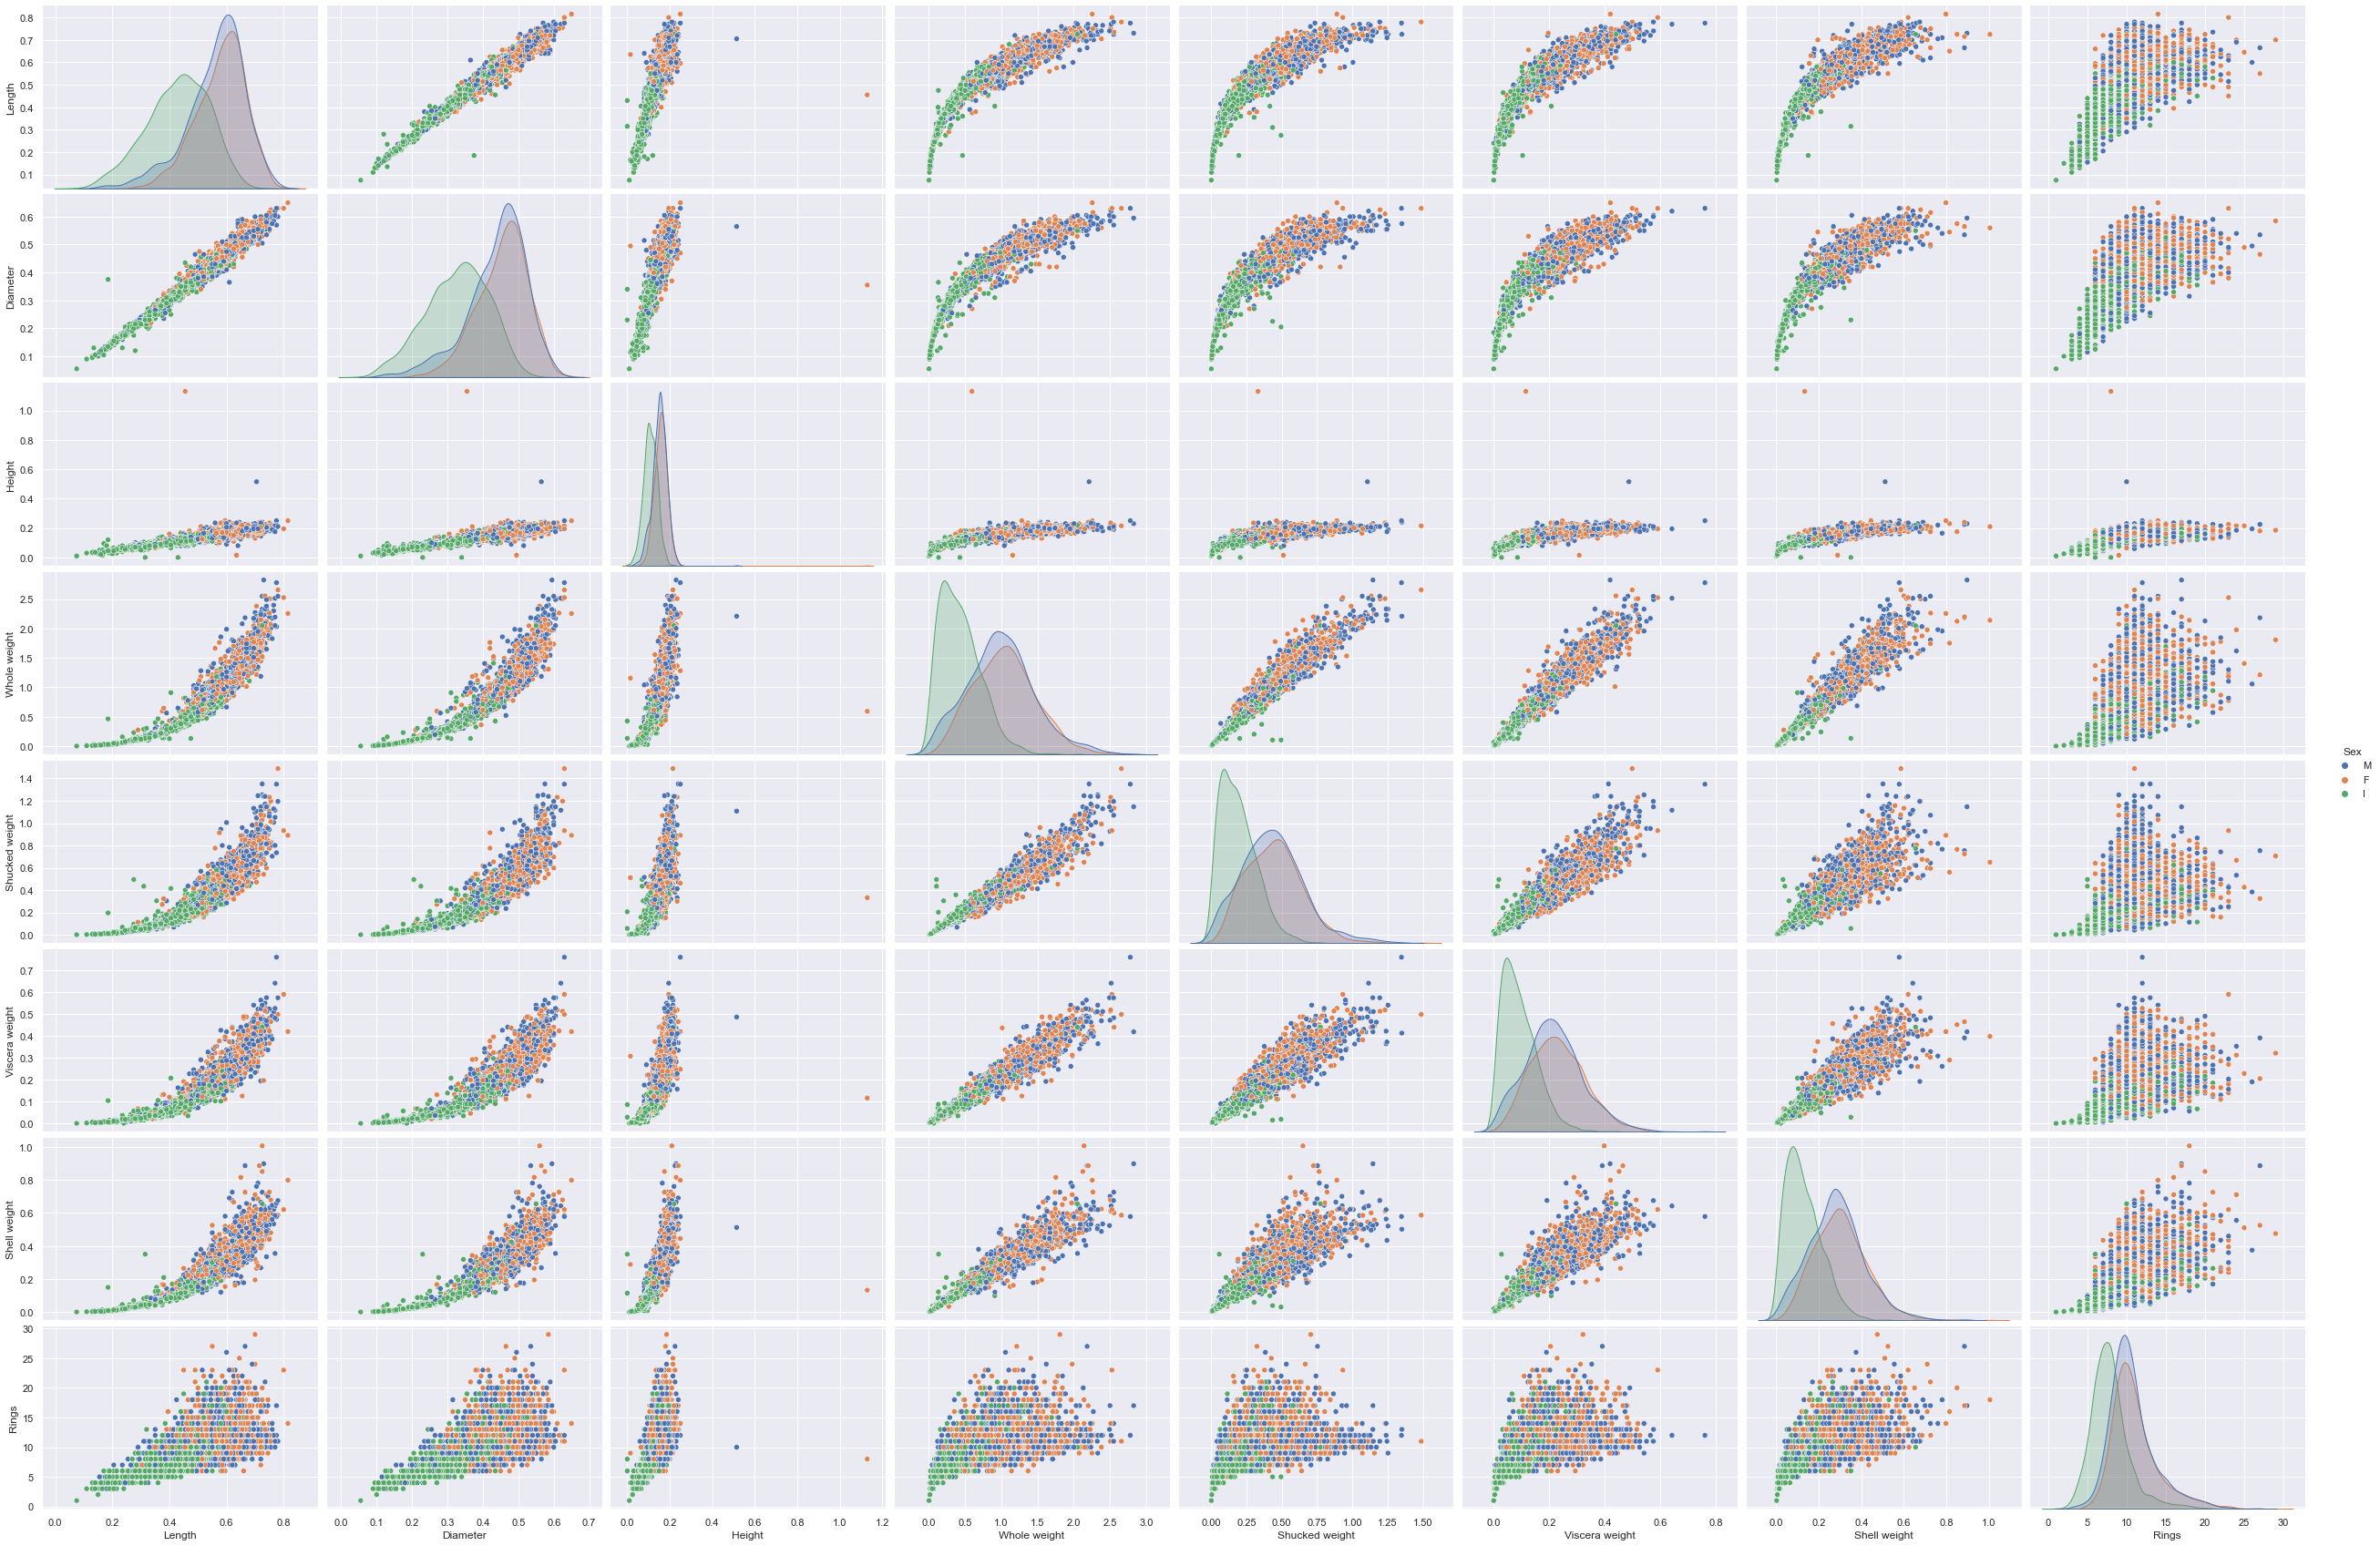

In [44]:
sns.pairplot(df, hue="Sex", height=3, aspect = 1.5)
plt.show()

In [45]:
y_labels = df["Sex"]
X = df.drop("Sex", axis=1)

# create a dictionary with the our int labels
labels_multi = dict(zip(y_labels.unique(), range(3)))

# make a binary version - infants vs. adults
labels_bin = labels_multi.copy()
labels_bin['F'] = 0; labels_bin['I'] = 1

# replace the labels so they are now binary
y_bin = y_labels.replace(labels_bin)

There are three classes for SVM classification in Scikit-Learn<sup>Geron</sup>:

| Class                | Time Complexity                                                                      | Out-of-core Support | Kernel Trick|
|------------------------|-------------------------------------------------------------------------------------------|---------------------------------|--------------------|
| LinearSVC       | 0(*m* x *n*)                                                                               | No                               | No                |
| SGDClassifier | 0(*m* x *n*)                                                                               | Yes                              | No                |
| SVC                  | 0(*m*<sup>2</sup> x *n*) to 0(*m*<sup>3</sup> x *n*) | No                               | Yes               |

_"Standard solvers take $O(N^3)$ time. However, specialized algorithms, which avoid the use of generic QP solvers, have been developed for this problem, such as the sequential minimal optimization or SMO algorithm (Platt 1998). In practice this can take $O(N^2)$. However, even this can be too slow if $N$ is large. In such settings, it is common to use linear SVMs, which take $O(N)$ time to train (Joachims 2006; Bottou et al. 2007)."_ ML a prob perspective

First lets make a pipeline with two steps:

1. Standardize the features
2. LinearSVC / SVC

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X.values, y_bin.values, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

linear_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(random_state=42))
    ])

rbf_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(random_state=42))])

linear_svm.fit(X_train, y_train)
rbf_svm.fit(X_train, y_train)

print("linear_svm")
display(pd.DataFrame(classification_report(y_val, linear_svm.predict(X_val), output_dict=True)))

print("rbf_svm")
display(pd.DataFrame(classification_report(y_val, rbf_svm.predict(X_val), output_dict=True)))

linear_svm


,0,1,accuracy,macro avg,weighted avg
precision,0.892938,0.665217,0.814649,0.779078,0.824860
recall,0.835821,0.765000,0.814649,0.800410,0.814649
f1-score,0.863436,0.711628,0.814649,0.787532,0.818053
support,469.000000,200.000000,0.814649,669.000000,669.000000


rbf_svm


,0,1,accuracy,macro avg,weighted avg
precision,0.884120,0.719212,0.834081,0.801666,0.834820
recall,0.878465,0.730000,0.834081,0.804232,0.834081
f1-score,0.881283,0.724566,0.834081,0.802925,0.834432
support,469.000000,200.000000,0.834081,669.000000,669.000000


## Choosing Hyperparameters

So that was quite simple, but we are only using the default hyperparamters which is not good. Lets look at finding some better hyperparameters.

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import uniform
from time import time

# specify parameters and distributions to sample from
param_dist = {'svm_clf__class_weight': [None, "balanced"],
              'svm_clf__C':list(range(1,50))}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(linear_svm, param_distributions=param_dist,
                                   n_iter=n_iter_search, random_state=42)
start = time()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates" % ((time() - start), n_iter_search))
pd.DataFrame(random_search.cv_results_).sort_values("rank_test_score")[["param_svm_clf__class_weight", "param_svm_clf__C", "mean_test_score", "std_test_score"]].head()

RandomizedSearchCV took 6.18 seconds for 20 candidates


,param_svm_clf__class_weight,param_svm_clf__C,mean_test_score,std_test_score
14,None,23,0.823733,0.011409
17,None,7,0.822235,0.013053
9,None,1,0.821860,0.012871
15,None,3,0.821860,0.012871
1,None,21,0.821857,0.011044


In [48]:
# specify parameters and distributions to sample from
param_dist = {'svm_clf__class_weight': [None, "balanced"],
              'svm_clf__C':list(range(1,50)),
              'svm_clf__gamma':uniform(0,1)}

# run randomized search
n_iter_search = 20
random_search_rbf = RandomizedSearchCV(rbf_svm, param_distributions=param_dist,
                                   n_iter=n_iter_search, random_state=42)
start = time()
random_search_rbf.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates" % ((time() - start), n_iter_search))
pd.DataFrame(random_search_rbf.cv_results_).sort_values("rank_test_score")[["param_svm_clf__class_weight", "param_svm_clf__C", "mean_test_score", "std_test_score"]].head()

RandomizedSearchCV took 20.01 seconds for 20 candidates


,param_svm_clf__class_weight,param_svm_clf__C,mean_test_score,std_test_score
14,None,21,0.832334,0.011647
13,None,3,0.828966,0.010244
7,None,21,0.828593,0.005631
15,None,4,0.828219,0.007217
11,None,16,0.827469,0.005509


Just from above we have improved our RBF scores, although no linear SVM much.

In [49]:
print("linear_svm")
display(pd.DataFrame(classification_report(y_val, random_search.best_estimator_.predict(X_val), output_dict=True)))

print("rbf_svm")
display(pd.DataFrame(classification_report(y_val, random_search_rbf.best_estimator_.predict(X_val), output_dict=True)))

linear_svm


,0,1,accuracy,macro avg,weighted avg
precision,0.897912,0.655462,0.811659,0.776687,0.825431
recall,0.825160,0.780000,0.811659,0.802580,0.811659
f1-score,0.860000,0.712329,0.811659,0.786164,0.815853
support,469.000000,200.000000,0.811659,669.000000,669.000000


rbf_svm


,0,1,accuracy,macro avg,weighted avg
precision,0.881607,0.734694,0.838565,0.808150,0.837687
recall,0.889126,0.720000,0.838565,0.804563,0.838565
f1-score,0.885350,0.727273,0.838565,0.806312,0.838092
support,469.000000,200.000000,0.838565,669.000000,669.000000


## Imballanced Data

In [60]:
from collections import Counter

print(Counter(y_train))

Counter({0: 1797, 1: 875})


## Multi-Class
__TODO__
- change the data to the bigger data instead of the Iris.
- add in the limitations of multi-class SVM from ML a probablistic perspective (pg. 509)

Some models (e.g. tree-based classifiers) are inherently multiclass, whereas other machine learning algorithms are able to be extended to multi-class classification using techniques such as the One-versus-Rest or One-versus-One methods<sup>Géron</sup>.

### One-verses-all (or One-vs-the-rest) 

The _One-verses-all_ approach is were you train a classifier for each class and select the class from the classifier that outputs the highest score<sup>Géron</sup>. In other terms, if we fit $K$ SVMs, we assign a test observation ($x^*$) to the class for which $\beta_{0k} + \beta_{1k}x^*_1, ...,\beta_{pk}x^*_p$ is largest (the most confident)<sup>James</sup>. 

As each class is fitted against all other classes for each classifier, it is relatively interpretable<sup>web1</sup>.

In [61]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

rbf = SVC(C=100, kernel='rbf', random_state=42)

multi_rbf = Pipeline([
    ('scl', StandardScaler()),
    ('clf', OneVsRestClassifier(rbf))])

display(cross_val_score(multi_rbf, iris_df, target, cv=3))

array([0.96, 0.92, 0.94])

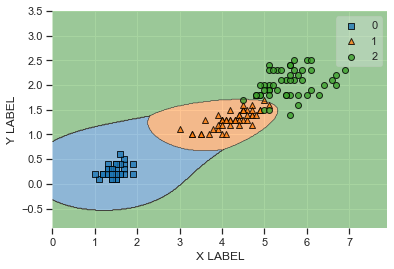

In [62]:
from mlxtend.plotting import plot_decision_regions
multi_rbf.fit(iris_df[["petal length (cm)", "petal width (cm)"]], target)

plot_decision_regions(iris_df[["petal length (cm)", "petal width (cm)"]].values,
                      target.values,
                      clf = multi_rbf)

plt.xlabel("X LABEL") 
plt.ylabel("Y LABEL")
#plt.xlim(0,.6)
#plt.ylim(0,1.)
plt.show()

### OneVsOneClassifer

Another strategy is to use a _OneVsOne_ approach. This trains $N \times (N-1) / 2$ classifiers by comparing each class against each other so when a prediction is made, the class that is selected the most is chosen<sup>Géron</sup> (we'll get more onto *Bagging* next week). It is useful where algorithms do not scale well with data size (such as SVM) because each training and prediction is only needed to be run on a small subset of the data for each classifer<sup>Géron,web1</sup>.

In [63]:
from sklearn.multiclass import OneVsOneClassifier

multi_rbf = Pipeline([
    ('scl', StandardScaler()),
    ('clf', OneVsOneClassifier(rbf))])

display(cross_val_score(multi_rbf, iris_df, target, cv=3))

array([0.94, 0.92, 0.96])

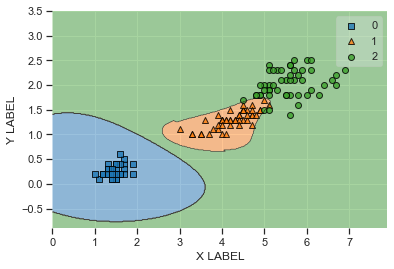

In [64]:
from mlxtend.plotting import plot_decision_regions
multi_rbf.fit(iris_df[["petal length (cm)", "petal width (cm)"]], target)

plot_decision_regions(iris_df[["petal length (cm)", "petal width (cm)"]].values,
                      target.values,
                      clf = multi_rbf)

plt.xlabel("X LABEL") 
plt.ylabel("Y LABEL")
#plt.xlim(0,.6)
#plt.ylim(0,1.)
plt.show()

## Advantages

- Kernels allow us to constuct hyperplanes in high dimensional spaces but with tractable computation<sup>6</sup>

- Provided hyper-parameters are carefully selected, compared to other ML methods, SVM's are not as effected by an over-representation of data in the training phase due to over-parameterization or over-fitting (Gonzalez-Vellon et al., 2003; Shoeb et al., 2004).

- SVMs always converge on the same answer given identical data and hyper-parameters.

## Disadvantages

_"Perhaps the biggest limitation of the support vector approach lies in choice of the kernel. Once the kernel is fixed, SVM classifiers have only one user-chosen parameter (the error penalty), but the kernel is a very big rug under which to sweep parameters. Some work has been done on limiting kernels using prior knowledge (Scholkopf et al., 1998a; Burges, 1998), but the best choice of kernel for a given problem is still a research issue."_ Burges (1998)

- Non-linear SVM's have a problem with speed with very large datasets, although the use of batch algorithms has improved this somewhat<sup>11</sup>

- Discrete data presents a problem for the SVM method we have discussed, however there are alternative implimentations in the litriture<sup>10</sup> 

- They are comparatively sensitive to hyperparamters, there can be quite a variation in score depending on setup.

# References
1. Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. Annals of eugenics, 7(2), 179-188.
2. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".
5. Raschka, 2016

web1.  https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

web2. https://scikit-learn.org/stable/datasets/toy_dataset.html

# NOTES
- https://scikit-learn.org/stable/auto_examples/exercises/plot_iris_exercise.html#sphx-glr-auto-examples-exercises-plot-iris-exercise-py